In [1]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 8.5 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


In [3]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from datasets import Dataset
from torch.cuda import amp
from transformers import AutoModel, AutoTokenizer,AutoConfig
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import torch
import warnings
import random
warnings.filterwarnings('ignore')
from collections import defaultdict
import torch.nn as nn
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from collections import defaultdict
import gc
gc.enable()

In [4]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [5]:
splits = {'train': 'cleaned_train_multi.csv', 'test': 'cleaned_test_multi.csv'}
train_df = pd.read_csv("hf://datasets/kcrl/Shared_Task_Fake_News_Multi/" + splits["train"])
test_df = pd.read_csv("hf://datasets/kcrl/Shared_Task_Fake_News_Multi/" + splits["test"])

In [6]:
with pd.option_context('display.max_colwidth',0):
    display(train_df.sample(n=10))

,ID,News,Label
1434,FAKE_MAL_TR_1435,ജൂൺ 1 മുതൽ ഒരു മാസത്തിൽ നാല് എടിഎം പിൻവലിക്കലുകൾക്ക് ശേഷം നിങ്ങളുടെ ബാങ്ക് അക്കൗണ്ടിൽ നിന്ന് 173 രൂപ അധിക ചാർജ് ഈടാക്കും.,MOSTLY FALSE
912,FAKE_MAL_TR_0913,കോവിഡ് 19 പ്രതിരോധ മന്ത്രി പിണറായി വിജയനെ മെൽബണിൽ ആദരിച്ചു,HALF TRUE
1415,FAKE_MAL_TR_1416,സമ്പന്നര് ക്ക് നികുതി നല് കണമെന്നും ദരിദ്രര് ക്ക് സബ് സിഡി നല് കണമെന്നും ആവശ്യപ്പെട്ട് പാകിസ്ഥാനിലുടനീളമുള്ള ഉയര് ന്ന വൈദ്യുതി ബില്ലുകള് ക്കെതിരായ പ്രതിഷേധത്തെക്കുറിച്ച് ഐഎംഎഫ് ഒരു 'വലിയ പ്രസ്താവന' പുറപ്പെടുവിച്ചതായി ക്യാപിറ്റല് ടിവി വാര് ത്ത നല് കി.,FALSE
1329,FAKE_MAL_TR_1330,അടുത്തിടെ ഹാപൂരിൽ അഭിഭാഷകർക്ക് നേരെയുണ്ടായ ലാത്തിച്ചാർജിൽ പ്രതിഷേധിച്ച് ഉത്തർപ്രദേശ് സർക്കാരിന്റെ ശവസംസ്കാര ഘോഷയാത്ര അഭിഭാഷകർ നടത്തി.,FALSE
71,FAKE_MAL_TR_0072,ശബരിമല-പമ്പ റോഡിൽ പശുവിനെ പുലി പിടിക്കുന്നു.,FALSE
1207,FAKE_MAL_TR_1208,ട്രെയിനിൽ ടിക്കറ്റില്ലാതെ യാത്ര ചെയുന്ന പെൺകുട്ടിയുടെ കഥ സുധ മൂർത്തിയുടെ ബാല്യകാലത്തിൽ നിന്നുള്ളതല്ല,MOSTLY FALSE
262,FAKE_MAL_TR_0263,വിമാനം വൈകിയതിന് യാത്രക്കാരോട് ക്ഷമ പറയുന്ന ജപ്പാന്‍ എയര്‍ലൈന്‍സ് ജീവനക്കാര്‍.,MOSTLY FALSE
108,FAKE_MAL_TR_0109,കേരളത്തിലെ 21 മന്ത്രിമാര്‍ക്കും കൂടി 1110 പേഴ്‌സണല്‍ സ്റ്റാഫുകളെ നിയമിച്ചിട്ടുണ്ട്.,HALF TRUE
1544,FAKE_MAL_TR_1545,മാമ്പഴം കഴിച്ച ശേഷം ശീതളപാനീയങ്ങൾ കുടിക്കുന്നത് മാരകമാണ്,FALSE
308,FAKE_MAL_TR_0309,സിനിമാമേഖലയിലെ തൻ്റെ അഭിനയവഴികൾ ജാക്കി ചാൻ മകൾക്കൊപ്പമിരുന്നു കാണുന്നതിൻ്റെ ദൃശ്യങ്ങൾ,FALSE


In [7]:
train_df.Label.unique()

array(['FALSE', 'HALF TRUE', 'MOSTLY FALSE', 'PARTLY FALSE'], dtype=object)

In [8]:
labeling = {
    'FALSE': 0,
    'HALF TRUE':1,
    'MOSTLY FALSE':2,
    'PARTLY FALSE':3
}
train_df['Label'] = train_df['Label'].apply(lambda x : labeling[x])

In [9]:
with pd.option_context('display.max_colwidth',0):
    display(train_df.sample(n=5))

,ID,News,Label
475,FAKE_MAL_TR_0476,"ബിസിസിഐ ഇന്ത്യന്‍ ക്രിക്കറ്റിനെ നശിപ്പിച്ചു', തുറന്നടിച്ച് സുനില്‍ ഗവാസ്‌കര്‍; ട്വീറ്റില്‍ ഒരു പ്രശ്‌നമുണ്ട്",0
727,FAKE_MAL_TR_0728,പോപ്പുലര്‍ ഫ്രണ്ട് ഹര്‍ത്താല്‍ പിന്‍വലിച്ചു,0
934,FAKE_MAL_TR_0935,ജന്മഭൂമി എഡിഷനുമായി നിൽക്കുന്ന കെ സുരേന്ദ്രന്റെ ഈ ചിത്രം ഫോട്ടോഷോപ്പ് ചെയ്തതാണോ?,0
1203,FAKE_MAL_TR_1204,2019ലെ ദീപാവലി ആഘോഷത്തില് അനാഥക്കുട്ടിക്ക് സഹായവുമായി യോഗി ആദിത്യനാഥ്,0
1178,FAKE_MAL_TR_1179,ഇന്ത്യയുടെ പുതിയ ഷൂട്ടിംഗ് താരം റിഥം സംഗ്വാൻ ഇപ്പോൾ ബാക്കുവിൽ നടക്കുന്ന ഐ എസ് എസ് എഫ് ലോകകപ്പിൽ ലോകറിക്കാർഡ് ഭേദിച്ചു.,0


In [10]:
train_df.Label.unique()

array([0, 1, 2, 3])

In [11]:
train_df.groupby('Label').size()

Label
0    1386
1     162
2     295
3      57
dtype: int64

In [12]:
train_df.shape

(1900, 3)

In [13]:
# from sklearn.model_selection import train_test_split

# # Assuming you have features X and labels y
# X_train, X_test, y_train, y_test = train_test_split(train_df['News'].values, train_df['Label'].values, test_size=0.2, random_state=42, stratify=train_df['Label'].values)


In [14]:
# len(X_train), len(X_test), len(y_train), len(y_test)

In [15]:

# train_df = pd.DataFrame(X_train, columns=['News'])
# train_df['Label'] = y_train  
# val_df = pd.DataFrame(X_test, columns=['News'])
# val_df['Label'] = y_test  

In [16]:
train_df.groupby('Label').size()

Label
0    1386
1     162
2     295
3      57
dtype: int64

In [17]:
from sklearn.utils import resample

# Set the target number of instances for minority classes
target_minority_count = 200

for minority_class in [1,2,3]:
    minority_indices = train_df[train_df['Label'] == minority_class].index
    minority_data = train_df.loc[minority_indices]
    
    minority_oversampled = resample(
        minority_data,
        replace=True,
        n_samples=target_minority_count,
        random_state=42
    )
    
    train_df = pd.concat([train_df, minority_oversampled], ignore_index=True)

In [18]:
train_df.groupby('Label').size()

Label
0    1386
1     362
2     495
3     257
dtype: int64

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      2500 non-null   object
 1   News    2500 non-null   object
 2   Label   2500 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 58.7+ KB


In [20]:
class Config:
    NUM_EPOCHS = 10
    NUM_FOLDS = 7
    BATCH_SIZE = 32
    MODEL_PATH = "FacebookAI/xlm-roberta-base"
    LR = 2e-5
    DROPOUT = 0.3
    NUM_CLASSES = 4
    SEED = 42
    MAX_LEN = 80
    DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

config  = Config()

In [21]:
train_df.loc[:, 'kfold'] = -1
train_df = train_df.sample(frac=1).reset_index(drop=True)

kfold = StratifiedKFold(n_splits=config.NUM_FOLDS, random_state=config.SEED, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df, train_df['Label'])):
    train_df.loc[val_idx, "kfold"] = fold
train_df.to_csv("train_data_folds.csv", index=False)

In [22]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

<Axes: ylabel='Count'>

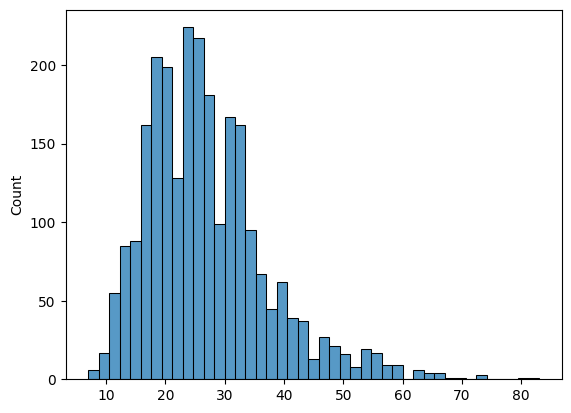

In [23]:
token_counts = []

for _, row in train_df.iterrows():
    text = str(row["News"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

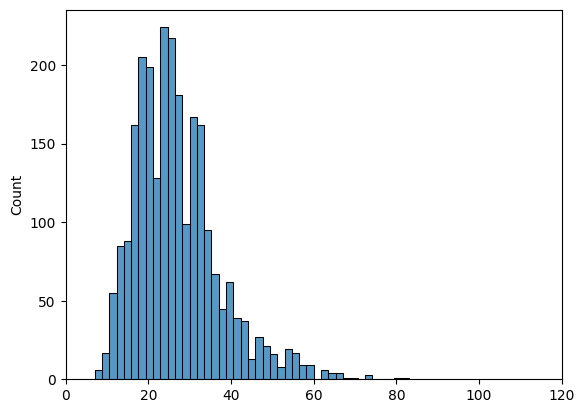

In [24]:
sns.histplot(token_counts)
plt.xlim([0, 120]);

In [26]:
class ClassifierDataset(Dataset):
    def __init__(self, df,tokenizer):
        super(ClassifierDataset, self).__init__()
        self.df = df 
        self.labels = torch.tensor(df.Label.values, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = config.MAX_LEN

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.iloc[index]["News"])
        inputs = self.tokenizer(
            text,
            padding=True, 
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        labels = self.labels[index]

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

In [27]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [28]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super(ClassifierModel,self).__init__()
        self.model_config = AutoConfig.from_pretrained(config.MODEL_PATH)
        self.model = AutoModel.from_pretrained(config.MODEL_PATH,config = self.model_config)
        # Adjusting input size for three pooling methods
        self.dense = torch.nn.Linear(self.model_config.hidden_size * 3, self.model_config.hidden_size)
        self.dropout = torch.nn.Dropout(config.DROPOUT)
        self.classifier = nn.Linear(self.model_config.hidden_size, config.NUM_CLASSES)
        
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids,attention_mask=attention_mask)
        last_hidden_state = output[0]
        
        # CLS token
        cls_token = last_hidden_state[:,0,:]
        
        # Mean pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        
        # Max pooling
        last_hidden_state[input_mask_expanded == 0] = -1e9 
        max_embeddings = torch.max(last_hidden_state, 1)[0]
        
        # Concatenate all three embeddings
        pooled = torch.cat((cls_token, mean_embeddings, max_embeddings), 1)
        pooler = self.dense(pooled)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [29]:
class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        pred = pred.cpu().numpy()
        y_pred = np.argmax(pred, axis = -1)
        f1 = f1_score(y_true, y_pred, average='macro')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(config.DEVICE)
            attention_mask = data["attention_mask"].to(config.DEVICE)            
            target = data["labels"].to(config.DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(config.DEVICE)  
                attention_mask = data["attention_mask"].to(config.DEVICE)              
                target = data["labels"].to(config.DEVICE)  
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [30]:
def run_training(fold, save_model = False):
    
    train_data = train_df[train_df.kfold != fold].reset_index(drop = True)
    val_data = train_df[train_df.kfold == fold].reset_index(drop = True)
    
    train_dataset = ClassifierDataset(train_data, tokenizer)    
    val_dataset = ClassifierDataset(val_data, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size = config.BATCH_SIZE,
                               shuffle =True, collate_fn = data_collator,num_workers=2)    
    val_loader = DataLoader(val_dataset, batch_size = config.BATCH_SIZE,
                            drop_last=False, shuffle=False,  collate_fn=data_collator, num_workers=2)   
    set_random_seed(config.SEED + fold)
    model = ClassifierModel()
    model.to(config.DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr= 2e-5, weight_decay=0.01)
    num_training_steps = config.NUM_EPOCHS * len(train_loader)
    scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
    )
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 5
    early_stopping_counter = 0
    best_score = 0.0
    print(f"Fold: {fold + 1}")
    for epoch in range(config.NUM_EPOCHS):
        train_loss = eng.train(train_loader,scaler,num_training_steps)
        val_score,val_loss = eng.evaluate(val_loader)
        
        print(f"Epoch: {epoch + 1} | Training_loss: {round(train_loss,5)} | Validation_loss: {round(val_loss,5)} | Score: {round(val_score,5)}")
        
        if val_score > best_score:
            best_score = val_score
            early_stopping_counter = 0
            
            if save_model:
                torch.save(model.state_dict(),f"model_{fold}.bin")
        else:
            early_stopping_counter +=1
            
        if early_stopping_counter > early_stopping_iter:
            break
            
    del model
    gc.collect()
            
    return best_score

In [ ]:
all_scores = []
for fold in range(config.NUM_FOLDS):
    temp_score =run_training(fold,save_model = True)
    all_scores.append(temp_score)

    print(f"Fold score:{temp_score}")

print(f"overall Score: {np.mean(all_scores)}")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Fold: 1


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | Training_loss: 1.16821 | Validation_loss: 1.14768 | Score: 0.19959


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

    Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
self._shutdown_workers()

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
self._shutdown_workers()
   

Epoch: 2 | Training_loss: 1.11117 | Validation_loss: 1.08375 | Score: 0.19959


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 3 | Training_loss: 1.08873 | Validation_loss: 1.0561 | Score: 0.23181


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 4 | Training_loss: 1.01537 | Validation_loss: 0.94361 | Score: 0.40209


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 5 | Training_loss: 0.93998 | Validation_loss: 0.89256 | Score: 0.44471


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 6 | Training_loss: 0.82303 | Validation_loss: 0.74254 | Score: 0.60493


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 7 | Training_loss: 0.6844 | Validation_loss: 0.69393 | Score: 0.6262


  0%|          | 0/670 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

    self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 8 | Training_loss: 0.59899 | Validation_loss: 0.6588 | Score: 0.64531


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 9 | Training_loss: 0.50594 | Validation_loss: 0.64237 | Score: 0.67126


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 10 | Training_loss: 0.4718 | Validation_loss: 0.63092 | Score: 0.67038
Fold score:0.671263435527516
Fold: 2


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | Training_loss: 1.17628 | Validation_loss: 1.12469 | Score: 0.19958


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 2 | Training_loss: 1.13187 | Validation_loss: 1.07459 | Score: 0.19958


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>

Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
if w.is_alive():self._shutdown_workers()    

self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/loc

Epoch: 3 | Training_loss: 1.02484 | Validation_loss: 0.93832 | Score: 0.4754


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 4 | Training_loss: 0.84162 | Validation_loss: 0.75529 | Score: 0.57345


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 5 | Training_loss: 0.67298 | Validation_loss: 0.74065 | Score: 0.63692


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 6 | Training_loss: 0.514 | Validation_loss: 0.80407 | Score: 0.66751


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 7 | Training_loss: 0.41258 | Validation_loss: 0.67935 | Score: 0.73992


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 8 | Training_loss: 0.30935 | Validation_loss: 0.76321 | Score: 0.70593


  0%|          | 0/670 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 9 | Training_loss: 0.24101 | Validation_loss: 0.64732 | Score: 0.76406


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 10 | Training_loss: 0.20437 | Validation_loss: 0.67641 | Score: 0.73962
Fold score:0.7640567012468695
Fold: 3


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | Training_loss: 1.16184 | Validation_loss: 1.11275 | Score: 0.17782


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 2 | Training_loss: 1.06653 | Validation_loss: 1.0025 | Score: 0.23371


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 3 | Training_loss: 0.87873 | Validation_loss: 0.84941 | Score: 0.63399


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 4 | Training_loss: 0.67764 | Validation_loss: 0.70225 | Score: 0.69461


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 5 | Training_loss: 0.48898 | Validation_loss: 0.64355 | Score: 0.73194


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 6 | Training_loss: 0.3552 | Validation_loss: 0.68239 | Score: 0.71775


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 7 | Training_loss: 0.241 | Validation_loss: 0.75776 | Score: 0.73007


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 8 | Training_loss: 0.18887 | Validation_loss: 0.76682 | Score: 0.74853


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>        
self._shutdown_workers()self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
            self._shutdown_worke

Epoch: 9 | Training_loss: 0.14249 | Validation_loss: 0.72574 | Score: 0.76287


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 10 | Training_loss: 0.11174 | Validation_loss: 0.72215 | Score: 0.76838
Fold score:0.7683815998949456
Fold: 4


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | Training_loss: 1.16931 | Validation_loss: 1.17028 | Score: 0.17563


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 2 | Training_loss: 1.10543 | Validation_loss: 1.10672 | Score: 0.20182


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 3 | Training_loss: 1.02676 | Validation_loss: 0.99119 | Score: 0.2936


  0%|          | 0/670 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():

AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 4 | Training_loss: 0.87814 | Validation_loss: 0.8743 | Score: 0.52311


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 5 | Training_loss: 0.70342 | Validation_loss: 0.6855 | Score: 0.65869


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 6 | Training_loss: 0.52404 | Validation_loss: 0.7128 | Score: 0.71021


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 7 | Training_loss: 0.40528 | Validation_loss: 0.68898 | Score: 0.7212


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 8 | Training_loss: 0.31991 | Validation_loss: 0.529 | Score: 0.78286


  0%|          | 0/670 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 9 | Training_loss: 0.25173 | Validation_loss: 0.53912 | Score: 0.77649


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 10 | Training_loss: 0.21038 | Validation_loss: 0.55438 | Score: 0.78655
Fold score:0.7865535941364449
Fold: 5


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | Training_loss: 1.16262 | Validation_loss: 1.12257 | Score: 0.19923


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 2 | Training_loss: 1.13279 | Validation_loss: 1.10307 | Score: 0.19923


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 3 | Training_loss: 1.05998 | Validation_loss: 1.00073 | Score: 0.35027


  0%|          | 0/670 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>Exception ignored in: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 4 | Training_loss: 0.98596 | Validation_loss: 0.89115 | Score: 0.44363


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 5 | Training_loss: 0.89691 | Validation_loss: 0.83116 | Score: 0.46777


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>Traceback (most recent call last):
can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
        if w.is_alive():
if w.is_alive():  File "/usr/lib/p

Epoch: 6 | Training_loss: 0.79776 | Validation_loss: 0.77382 | Score: 0.55949


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 7 | Training_loss: 0.68712 | Validation_loss: 0.71215 | Score: 0.60224


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 8 | Training_loss: 0.60445 | Validation_loss: 0.70773 | Score: 0.64897


  0%|          | 0/670 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 9 | Training_loss: 0.53035 | Validation_loss: 0.75988 | Score: 0.59861


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 10 | Training_loss: 0.4764 | Validation_loss: 0.66322 | Score: 0.66261
Fold score:0.6626085623812016
Fold: 6


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | Training_loss: 1.16672 | Validation_loss: 1.05856 | Score: 0.24486


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 2 | Training_loss: 1.03949 | Validation_loss: 0.88431 | Score: 0.36155


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 3 | Training_loss: 0.84187 | Validation_loss: 0.76612 | Score: 0.62034


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 4 | Training_loss: 0.64106 | Validation_loss: 0.62627 | Score: 0.67419


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 5 | Training_loss: 0.45864 | Validation_loss: 0.54377 | Score: 0.75669


  0%|          | 0/670 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20><function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionErrorif w.is_alive():: 
can only test a child process
  File "/usr/lib/

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 6 | Training_loss: 0.31625 | Validation_loss: 0.64613 | Score: 0.72388


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 7 | Training_loss: 0.23071 | Validation_loss: 0.58162 | Score: 0.77357


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 8 | Training_loss: 0.15745 | Validation_loss: 0.58786 | Score: 0.76171


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 9 | Training_loss: 0.13215 | Validation_loss: 0.54592 | Score: 0.7885


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 10 | Training_loss: 0.1206 | Validation_loss: 0.58873 | Score: 0.75675
Fold score:0.7884998763225819
Fold: 7


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | Training_loss: 1.18181 | Validation_loss: 1.14741 | Score: 0.18826


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 2 | Training_loss: 1.08378 | Validation_loss: 1.06897 | Score: 0.26662


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 3 | Training_loss: 0.94818 | Validation_loss: 1.02669 | Score: 0.49429


  0%|          | 0/670 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x7c70171c5a20>    self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 4 | Training_loss: 0.75511 | Validation_loss: 0.99443 | Score: 0.5314


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 5 | Training_loss: 0.55201 | Validation_loss: 0.93125 | Score: 0.60818


  0%|          | 0/670 [00:00<?, ?it/s]